In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image
from glob import glob
from skimage.io import imread

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

import time
import copy
from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

print('Imports complete')


Imports complete


In [ ]:
labels=pd.read_csv("/content/drive/MyDrive/PRML project/Random_Sample/labels_sampled.csv")

In [ ]:
labels=labels.drop(['Unnamed: 0'],axis=1)

In [ ]:
labels

,id,label
0,11a68ca42b1d39a294f583bff78e02d3ba2fd351,1
1,f42dc1a114133887775d89a92c5572eedd151ce3,1
2,4377658e3f44232420819ed70f5d04c83cc2a183,1
3,c202ef01e9a4b002a58eb2284dbde87244e3c27a,0
4,1e8f4b97644bb654fe24e07c175f38d682520dd3,1
...,...,...
5495,da7e9c8880a251a7f3a7a69debdaa99fc63f88de,1
5496,9149e1c41d80e09eee71e88b4477b5eea17ea568,1
5497,c43409816e668aea392040ca457b159abc38c7e3,0
5498,53ef9a25f03b08ca735e136fa9e03a9349764aff,0


## What are Dimensions??

In [ ]:
! pip3 install raster2xyz

  Created wheel for raster2xyz: filename=raster2xyz-0.1.3-py3-none-any.whl size=5964 sha256=b540f10112d97c44cac34985d95056754e29c724053af78615840bc903272f88
  Stored in directory: /root/.cache/pip/wheels/07/4b/5d/fc666340cb735a7a79d149be0acd64dff8edec947dba612d70
Successfully built raster2xyz


In [ ]:
from raster2xyz.raster2xyz import Raster2xyz

input_raster = "/content/drive/MyDrive/PRML project/Random_Sample/Train/0013241318e68fd3eaca389171d248f9cee0af12.tif"
out_csv = "demo_out_xyz.csv"

rtxyz = Raster2xyz()
rtxyz.translate(input_raster, out_csv)

myRasterDF = pd.read_csv(out_csv)

myRasterDF


[2022-05-02 07:07:17 - INFO] - Getting geotransform and data...
[2022-05-02 07:09:07 - INFO] - Getting XYZ data...
[2022-05-02 07:09:07 - INFO] - Getting geotransformed coordinates...
[2022-05-02 07:09:07 - INFO] - Building XYZ data...
[2022-05-02 07:09:07 - INFO] - New XYZ (csv file) created...


,x,y,z
0,0.5,0.5,179
1,1.5,0.5,255
2,2.5,0.5,243
3,3.5,0.5,199
4,4.5,0.5,202
...,...,...,...
9211,91.5,95.5,226
9212,92.5,95.5,219
9213,93.5,95.5,223
9214,94.5,95.5,228


--------------------------------------------------------------------------------
**So one .tif image has dimensions (96x96x3) where 3 corresponds to the number of channels that the image has.**

## Complete Random Sampled load

In [ ]:
from PIL import Image

In [ ]:
IMG_WIDTH=96
IMG_HEIGHT=96
img_folder=r'/content/drive/MyDrive/PRML project/Random_Sample/Train'

In [ ]:
import random
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
def create_dataset_PIL(img_folder,labels):
    
    img_data_array=[]
    class_name=[]
    for file in range(len(labels)):
       
            image_path= os.path.join(img_folder,  labels['id'][file]+'.tif')
            image= np.array(Image.open(image_path))
            image = image.astype('float32')
            image /= 255  
            img_data_array.append(image)
            class_name.append(labels['label'][file])
    return img_data_array , class_name
PIL_img_data, class_name=create_dataset_PIL(img_folder,labels)

In [ ]:
len(PIL_img_data)

5500

In [ ]:
PIL_img_data[0].shape

(96, 96, 3)

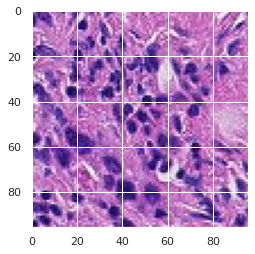

In [ ]:
a=PIL_img_data[0]
plt.imshow(a)

In [ ]:
PIL_img_data[0]

array([[[0.69411767, 0.34901962, 0.7411765 ],
        [0.8352941 , 0.53333336, 0.9098039 ],
        [0.54901963, 0.3137255 , 0.6666667 ],
        ...,
        [0.8901961 , 0.7176471 , 1.        ],
        [0.2901961 , 0.15294118, 0.52156866],
        [0.21960784, 0.09411765, 0.5137255 ]],

       [[0.5137255 , 0.21568628, 0.60784316],
        [0.68235296, 0.41960785, 0.8       ],
        [0.40784314, 0.19215687, 0.5568628 ],
        ...,
        [0.8862745 , 0.72156864, 0.96862745],
        [0.72156864, 0.56078434, 0.8666667 ],
        [0.27058825, 0.09411765, 0.45882353]],

       [[0.32156864, 0.10196079, 0.48235294],
        [0.47843137, 0.26666668, 0.6431373 ],
        [0.49411765, 0.29803923, 0.67058825],
        ...,
        [0.8627451 , 0.70980394, 0.88235295],
        [0.7647059 , 0.5647059 , 0.79607844],
        [0.4745098 , 0.23137255, 0.5176471 ]],

       ...,

       [[0.45882353, 0.4117647 , 0.67058825],
        [0.16078432, 0.06666667, 0.3647059 ],
        [0.4392157 , 0

In [ ]:
flatten=[]
for i in PIL_img_data:
  flatten.append(i.flatten())
flatten = np.array(flatten)
flatten.shape

(5500, 27648)

In [ ]:
# import scipy.cluster.hierarchy as shc
# from matplotlib import pyplot
# pyplot.figure(figsize=(10, 7))  
# pyplot.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(flatten, method='ward'))

In [ ]:
flatten.shape

(5500, 27648)

## Principal Component Analysis

In [ ]:
pca = PCA(n_components = 0.98)
pca.fit(flatten,class_name)

PCA(n_components=0.98)

In [ ]:
pca_data = pca.transform(flatten)
print("number of features is : ",len(pca_data[0]))

number of features is :  3400


In [ ]:
pca = PCA(n_components= 0.95)
pca.fit(flatten,class_name)

PCA(n_components=0.95)

In [ ]:
pca_data = pca.transform(flatten)
print("number of features is : ",len(pca_data[0]))

number of features is :  2432


In [ ]:
pca = PCA(n_components = 0.9)
pca.fit(flatten,class_name)

In [ ]:
pca_data = pca.transform(flatten)
print("number of features is : ",len(pca_data[0]))

In [ ]:
pca = PCA(n_components = 2)
pca.fit(flatten,class_name)

PCA(n_components=2)

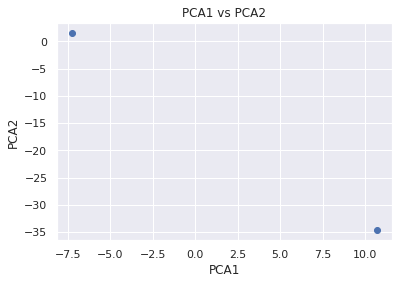

In [ ]:
pca_data = pca.transform(flatten)
plt.figure()
splot = plt.subplot(1,1,1)
splot.scatter(pca_data[0],pca_data[1])
plt.title('PCA1 vs PCA2')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [ ]:
pca80 = PCA(n_components = 0.8)
pca80.fit(flatten,class_name)
pca_data80 = pca80.transform(flatten)

In [ ]:
lda = LDA(store_covariance= True)
lda.fit(pca_data80,class_name)
lda_data = lda.transform(pca_data80)

In [ ]:
pca90 = PCA(n_components = 0.9)
pca90.fit(flatten,class_name)
pca_data90 = pca90.transform(flatten)

In [ ]:
lda = LDA(store_covariance= True)
lda.fit(pca_data90,class_name)
lda_data90 = lda.transform(pca_data90)

## Models - Without PCA

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(flatten,class_name,stratify=class_name,train_size=0.8,random_state=10)

### Linear Support Vector Classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       654
           1       0.52      0.57      0.54       446

    accuracy                           0.61      1100
   macro avg       0.60      0.61      0.60      1100
weighted avg       0.62      0.61      0.62      1100



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.77      0.53      0.62       654
           1       0.53      0.77      0.62       446

    accuracy                           0.62      1100
   macro avg       0.65      0.65      0.62      1100
weighted avg       0.67      0.62      0.62      1100



### RBF SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(random_state=0, gamma='auto'))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', random_state=0))])

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       654
           1       0.77      0.68      0.72       446

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.78      1100
weighted avg       0.79      0.79      0.79      1100



### Light GBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)

LGBMClassifier()

In [ ]:
y_pred = lgbm.predict(X_test)
acc = classification_report(y_test,y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       654
           1       0.78      0.66      0.72       446

    accuracy                           0.79      1100
   macro avg       0.79      0.77      0.77      1100
weighted avg       0.79      0.79      0.78      1100



## Models - With PCA 2 components

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(pca_data,class_name,stratify=class_name,train_size=0.8,random_state=10)

### Linear Support Vector Classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.67      0.83      0.74       654
           1       0.60      0.39      0.47       446

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.64      0.65      0.63      1100



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       654
           1       0.59      0.56      0.57       446

    accuracy                           0.66      1100
   macro avg       0.65      0.65      0.65      1100
weighted avg       0.66      0.66      0.66      1100



### RBF SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(random_state=0, gamma='auto'))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', random_state=0))])

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       654
           1       0.62      0.62      0.62       446

    accuracy                           0.69      1100
   macro avg       0.68      0.68      0.68      1100
weighted avg       0.69      0.69      0.69      1100



### Light GBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)

LGBMClassifier()

In [ ]:
y_pred = lgbm.predict(X_test)
acc = classification_report(y_test,y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.72      0.77      0.74       654
           1       0.62      0.55      0.59       446

    accuracy                           0.68      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.68      0.68      0.68      1100



## Models - With PCA 0.8

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(pca_data80,class_name,stratify=class_name,train_size=0.8,random_state=10)

### Linear Support Vector Classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       654
           1       0.55      0.58      0.57       446

    accuracy                           0.64      1100
   macro avg       0.63      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.78      0.49      0.60       654
           1       0.51      0.79      0.62       446

    accuracy                           0.61      1100
   macro avg       0.65      0.64      0.61      1100
weighted avg       0.67      0.61      0.61      1100



### RBF SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(random_state=0, gamma='auto'))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', random_state=0))])

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.73      0.89      0.80       654
           1       0.76      0.52      0.62       446

    accuracy                           0.74      1100
   macro avg       0.74      0.70      0.71      1100
weighted avg       0.74      0.74      0.73      1100



### Light GBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)

LGBMClassifier()

In [ ]:
y_pred = lgbm.predict(X_test)
acc = classification_report(y_test,y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       654
           1       0.77      0.67      0.72       446

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.78      0.79      0.78      1100



## Models - With PCA [0.8] and LDA

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(lda_data,class_name,stratify=class_name,train_size=0.8,random_state=10)

### Linear Support Vector Classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       654
           1       0.74      0.67      0.70       446

    accuracy                           0.77      1100
   macro avg       0.76      0.75      0.76      1100
weighted avg       0.77      0.77      0.77      1100



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       654
           1       0.68      0.67      0.68       446

    accuracy                           0.74      1100
   macro avg       0.73      0.73      0.73      1100
weighted avg       0.74      0.74      0.74      1100



### RBF SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(random_state=0, gamma='auto'))
clf.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', random_state=0))])

In [ ]:
y_pred=clf.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.81      0.82      0.81       654
           1       0.73      0.72      0.72       446

    accuracy                           0.78      1100
   macro avg       0.77      0.77      0.77      1100
weighted avg       0.78      0.78      0.78      1100



### Light GBM

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)

LGBMClassifier()

In [ ]:
y_pred = lgbm.predict(X_test)
acc = classification_report(y_test,y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       654
           1       0.72      0.69      0.70       446

    accuracy                           0.76      1100
   macro avg       0.76      0.75      0.75      1100
weighted avg       0.76      0.76      0.76      1100



## Models - With PCA [0.9] and LDA

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(lda_data90,class_name,stratify=class_name,train_size=0.8,random_state=10)

### Linear Support Vector Classifier

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
model = Pipeline((('scaler',StandardScaler()),('linear svc', LinearSVC(random_state=0, tol=1e-5))))
model.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear svc', LinearSVC(random_state=0, tol=1e-05))])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred=model.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       654
           1       0.82      0.77      0.80       446

    accuracy                           0.84      1100
   macro avg       0.84      0.83      0.83      1100
weighted avg       0.84      0.84      0.84      1100



#### Random Search CV

In [ ]:
clf = RandomizedSearchCV(model,{'linear svc__C':[0.25,2.5,25,250]})
clf.fit(X_train,y_train)
clf.best_params_

{'linear svc__C': 25}

In [ ]:
model = Pipeline((('scaler',StandardScaler()),('linear svc', LinearSVC(random_state=0,C = 25, tol=1e-5))))
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       654
           1       0.82      0.77      0.80       446

    accuracy                           0.84      1100
   macro avg       0.84      0.83      0.83      1100
weighted avg       0.84      0.84      0.84      1100



In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.01354499, 0.08916521, 0.11435103, 0.11647248]),
 'mean_score_time': array([0.00089245, 0.00119743, 0.00119052, 0.00119243]),
 'mean_test_score': array([0.82159091, 0.82159091, 0.82181818, 0.79659091]),
 'param_linear svc__C': masked_array(data=[0.25, 2.5, 25, 250],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'linear svc__C': 0.25},
  {'linear svc__C': 2.5},
  {'linear svc__C': 25},
  {'linear svc__C': 250}],
 'rank_test_score': array([2, 2, 1, 4], dtype=int32),
 'split0_test_score': array([0.825     , 0.825     , 0.82613636, 0.82386364]),
 'split1_test_score': array([0.82272727, 0.82272727, 0.82272727, 0.77272727]),
 'split2_test_score': array([0.82840909, 0.82840909, 0.82840909, 0.76590909]),
 'split3_test_score': array([0.82613636, 0.82613636, 0.82613636, 0.82272727]),
 'split4_test_score': array([0.80568182, 0.80568182, 0.80568182, 0.79772727]),
 'std_fit_time': array([0.00189637, 0.0050

#### Grid Search CV

In [ ]:
clf = GridSearchCV(model,{'linear svc__C':[0.25,2.5,25,250]})
clf.fit(X_train,y_train)
clf.best_params_

{'linear svc__C': 25}

In [ ]:
model = Pipeline((('scaler',StandardScaler()),('linear svc', LinearSVC(random_state=0,C = 25, tol=1e-5))))
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       654
           1       0.82      0.77      0.80       446

    accuracy                           0.84      1100
   macro avg       0.84      0.83      0.83      1100
weighted avg       0.84      0.84      0.84      1100



In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.03668747, 0.09091797, 0.11175628, 0.11458955]),
 'mean_score_time': array([0.00312943, 0.00118985, 0.00118756, 0.00120883]),
 'mean_test_score': array([0.82159091, 0.82159091, 0.82181818, 0.79659091]),
 'param_linear svc__C': masked_array(data=[0.25, 2.5, 25, 250],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'linear svc__C': 0.25},
  {'linear svc__C': 2.5},
  {'linear svc__C': 25},
  {'linear svc__C': 250}],
 'rank_test_score': array([2, 2, 1, 4], dtype=int32),
 'split0_test_score': array([0.825     , 0.825     , 0.82613636, 0.82386364]),
 'split1_test_score': array([0.82272727, 0.82272727, 0.82272727, 0.77272727]),
 'split2_test_score': array([0.82840909, 0.82840909, 0.82840909, 0.76590909]),
 'split3_test_score': array([0.82613636, 0.82613636, 0.82613636, 0.82272727]),
 'split4_test_score': array([0.80568182, 0.80568182, 0.80568182, 0.79772727]),
 'std_fit_time': array([0.01225854, 0.0060

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       654
           1       0.76      0.75      0.76       446

    accuracy                           0.80      1100
   macro avg       0.80      0.80      0.80      1100
weighted avg       0.80      0.80      0.80      1100



#### Random Search CV

In [ ]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [ ]:
clf = RandomizedSearchCV(neigh,grid_params)

In [ ]:
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': [5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']})

In [ ]:
clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}

In [ ]:
neigh = KNeighborsClassifier(metric = clf.best_params_['metric'],n_neighbors=clf.best_params_['n_neighbors'],weights=clf.best_params_['weights'])
neigh.fit(X_train, y_train)

y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       654
           1       0.78      0.80      0.79       446

    accuracy                           0.83      1100
   macro avg       0.82      0.83      0.82      1100
weighted avg       0.83      0.83      0.83      1100



In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.00263691, 0.00283265, 0.00219688, 0.00204201, 0.00220695,
        0.002036  , 0.00256081, 0.00331893, 0.00266137, 0.00229063]),
 'mean_score_time': array([0.02818918, 0.03447247, 0.02421398, 0.00279646, 0.02425632,
        0.00283756, 0.03030815, 0.00600185, 0.03211193, 0.00377574]),
 'mean_test_score': array([0.79840909, 0.81068182, 0.8125    , 0.77795455, 0.81068182,
        0.77840909, 0.81477273, 0.78636364, 0.81477273, 0.78295455]),
 'param_metric': masked_array(data=['euclidean', 'euclidean', 'manhattan', 'manhattan',
                    'manhattan', 'euclidean', 'manhattan', 'euclidean',
                    'euclidean', 'manhattan'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_neighbors': masked_array(data=[5, 9, 11, 5, 9, 7, 15, 15, 15, 11],
              mask=[False, False, False, False, False, False, False, False,
        

#### Grid Search CV

In [ ]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [ ]:
clf = GridSearchCV(neigh,grid_params)

In [ ]:
clf.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(metric='manhattan', n_neighbors=15),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']})

In [ ]:
clf.best_params_

{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}

In [ ]:
neigh = KNeighborsClassifier(metric = 'minkowski',n_neighbors=13,weights='uniform')
neigh.fit(X_train, y_train)

y_pred=neigh.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       654
           1       0.78      0.81      0.80       446

    accuracy                           0.83      1100
   macro avg       0.82      0.83      0.83      1100
weighted avg       0.83      0.83      0.83      1100



In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.00363631, 0.00299592, 0.00321426, 0.00341935, 0.00322247,
        0.00285034, 0.00324545, 0.00334148, 0.00266714, 0.00202665,
        0.00209966, 0.00201082, 0.00258279, 0.00198512, 0.00210519,
        0.00247827, 0.00217013, 0.00215335, 0.00212293, 0.00204687,
        0.0021349 , 0.00201144, 0.00214777, 0.00218935, 0.00212975,
        0.00249238, 0.00216923, 0.00196428, 0.00213466, 0.00267482,
        0.00221534, 0.00197344, 0.00212274, 0.00273004, 0.00214291,
        0.00200553]),
 'mean_score_time': array([0.03772302, 0.00367713, 0.04036884, 0.00419006, 0.04956884,
        0.00426641, 0.05884504, 0.00573258, 0.03338404, 0.00354605,
        0.0235877 , 0.00382595, 0.0252799 , 0.00254726, 0.02566776,
        0.00375576, 0.02740593, 0.00332699, 0.02355952, 0.00330601,
        0.02415352, 0.00353432, 0.02496057, 0.00402374, 0.02331181,
        0.0035522 , 0.02577724, 0.00296793, 0.02387891, 0.00394211,
        0.02494879, 0.00342917, 0.03479562, 0.00445046, 0.

### RBF SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
model = Pipeline((('scaler',StandardScaler()), ('rbf_svm',SVC(random_state=0, gamma='auto'))))
model.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rbf_svm', SVC(gamma='auto', random_state=0))])

In [ ]:
y_pred=model.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       654
           1       0.81      0.80      0.80       446

    accuracy                           0.84      1100
   macro avg       0.84      0.84      0.84      1100
weighted avg       0.84      0.84      0.84      1100



#### Random Search CV

In [ ]:
clf = RandomizedSearchCV(model,{'rbf_svm__C': [1,10,100,1000]})

In [ ]:
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('rbf_svm',
                                              SVC(gamma='auto',
                                                  random_state=0))]),
                   param_distributions={'rbf_svm__C': [1, 10, 100, 1000]})

In [ ]:
clf.best_params_

{'rbf_svm__C': 1000}

In [ ]:
model = Pipeline((('scaler',StandardScaler()), ('rbf_svm',SVC(random_state=0,C =1000, gamma='auto'))))
model.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rbf_svm', SVC(C=1000, gamma='auto', random_state=0))])

In [ ]:
y_pred=model.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       654
           1       0.82      0.79      0.80       446

    accuracy                           0.84      1100
   macro avg       0.84      0.83      0.84      1100
weighted avg       0.84      0.84      0.84      1100



In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.3949645 , 0.54278626, 1.22573776, 7.40844498]),
 'mean_score_time': array([0.07445335, 0.07050252, 0.07003474, 0.10698977]),
 'mean_test_score': array([0.8175    , 0.81772727, 0.81772727, 0.81909091]),
 'param_rbf_svm__C': masked_array(data=[1, 10, 100, 1000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'rbf_svm__C': 1},
  {'rbf_svm__C': 10},
  {'rbf_svm__C': 100},
  {'rbf_svm__C': 1000}],
 'rank_test_score': array([4, 2, 2, 1], dtype=int32),
 'split0_test_score': array([0.82159091, 0.82159091, 0.82272727, 0.825     ]),
 'split1_test_score': array([0.81818182, 0.81704545, 0.81704545, 0.81818182]),
 'split2_test_score': array([0.82272727, 0.825     , 0.825     , 0.825     ]),
 'split3_test_score': array([0.82727273, 0.82727273, 0.82727273, 0.82727273]),
 'split4_test_score': array([0.79772727, 0.79772727, 0.79659091, 0.8       ]),
 'std_fit_time': array([0.0149592 , 0.03841338, 0.1129689 , 1

#### Grid Search CV

In [ ]:
clf = GridSearchCV(model,{'rbf_svm__C': [1,10,100,1000]})

In [ ]:
clf.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rbf_svm',
                                        SVC(C=1000, gamma='auto',
                                            random_state=0))]),
             param_grid={'rbf_svm__C': [1, 10, 100, 1000]})

In [ ]:
clf.best_params_

{'rbf_svm__C': 1000}

In [ ]:
model = Pipeline((('scaler',StandardScaler()), ('rbf_svm',SVC(random_state=0,C =1000, gamma='auto'))))
model.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rbf_svm', SVC(C=1000, gamma='auto', random_state=0))])

In [ ]:
y_pred=model.predict(X_test)
acc=classification_report(y_test, y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       654
           1       0.82      0.79      0.80       446

    accuracy                           0.84      1100
   macro avg       0.84      0.83      0.84      1100
weighted avg       0.84      0.84      0.84      1100



In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.68344235, 1.06890645, 1.58816929, 6.16178093]),
 'mean_score_time': array([0.12226181, 0.11517658, 0.07845955, 0.07820439]),
 'mean_test_score': array([0.8175    , 0.81772727, 0.81772727, 0.81909091]),
 'param_rbf_svm__C': masked_array(data=[1, 10, 100, 1000],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'rbf_svm__C': 1},
  {'rbf_svm__C': 10},
  {'rbf_svm__C': 100},
  {'rbf_svm__C': 1000}],
 'rank_test_score': array([4, 2, 2, 1], dtype=int32),
 'split0_test_score': array([0.82159091, 0.82159091, 0.82272727, 0.825     ]),
 'split1_test_score': array([0.81818182, 0.81704545, 0.81704545, 0.81818182]),
 'split2_test_score': array([0.82272727, 0.825     , 0.825     , 0.825     ]),
 'split3_test_score': array([0.82727273, 0.82727273, 0.82727273, 0.82727273]),
 'split4_test_score': array([0.79772727, 0.79772727, 0.79659091, 0.8       ]),
 'std_fit_time': array([0.02303104, 0.26279693, 0.32332375, 1

### Light GBM

In [ ]:
lgbm = LGBMClassifier()
model = LGBMClassifier()
model.fit(X_train,y_train)

LGBMClassifier()

In [ ]:
y_pred = model.predict(X_test)
acc = classification_report(y_test,y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       654
           1       0.79      0.80      0.80       446

    accuracy                           0.83      1100
   macro avg       0.83      0.83      0.83      1100
weighted avg       0.83      0.83      0.83      1100



#### Random Search CV

In [ ]:
clf = RandomizedSearchCV(model,dict(num_leaves=[5,10,100,1000],max_depth = [2,3,4,5,6]))

In [ ]:
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'max_depth': [2, 3, 4, 5, 6],
                                        'num_leaves': [5, 10, 100, 1000]})

In [ ]:
clf.best_params_

{'max_depth': 4, 'num_leaves': 1000}

In [ ]:
model = LGBMClassifier(num_leaves = clf.best_params_['num_leaves'],max_depth = clf.best_params_['max_depth'])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc = classification_report(y_test,y_pred)
print(acc)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       654
           1       0.80      0.79      0.80       446

    accuracy                           0.83      1100
   macro avg       0.83      0.83      0.83      1100
weighted avg       0.83      0.83      0.83      1100



In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.05359406, 0.08835907, 0.05220914, 0.08916316, 0.05954132,
        0.04962168, 0.04586596, 0.04967332, 0.04577799, 0.03613124]),
 'mean_score_time': array([0.00559783, 0.00696006, 0.00503807, 0.00800166, 0.00527911,
        0.00491028, 0.00498075, 0.00458827, 0.00472884, 0.00425606]),
 'mean_test_score': array([0.81977273, 0.81840909, 0.81954545, 0.81636364, 0.81977273,
        0.81909091, 0.81954545, 0.81909091, 0.82068182, 0.81931818]),
 'param_max_depth': masked_array(data=[3, 5, 2, 6, 3, 6, 3, 4, 4, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_num_leaves': masked_array(data=[100, 1000, 1000, 100, 1000, 5, 5, 5, 1000, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 3, 'num_leaves': 100}

#### Grid Search CV

In [ ]:
clf = GridSearchCV(model,dict(num_leaves=[5,10,100,1000],max_depth = [2,3,4,5,6]))

In [ ]:
clf.fit(X_train,y_train)

In [ ]:
clf.best_params_

In [ ]:
model = LGBMClassifier(num_leaves = 100,max_depth = 4)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc = classification_report(y_test,y_pred)
print(acc)

In [ ]:
clf.cv_results_